# HW2：House Price Prediction
- 張誌翰 M1026424 數據碩一
- 賴泓瑜 D0856894 應數三乙 
***
- 題目來源：2017.1 ~ 2021.9 台中房價數據
- 特徵數量：16
    - 欄位 1~13、15、16：特徵欄位(類別、數值)
    - 欄位 14：預測目標欄位
        - 總價
- 樣本數：
    - train.csv: 30,000
    - test.csv: 1,000
- 評估指標：
    - RMSE=$\sqrt{\frac{1}{N}\sum_{i=1}^{N} (y_i - \hat{y_i})^2}$，N為 test data筆數
- 其他：
    - 需使用至少兩個不同模型，以作為比較（其中一個模型是線性迴歸）
    - 可引入外部資料
    - 預測結果需轉換為正整數
    - Public Score 不能比 base line低，否則不及格
***

## 讀取數據
***

* 匯入套件

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import warnings
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from category_encoders import TargetEncoder

warnings.filterwarnings("ignore")
from scipy import stats
my_font = fm.FontProperties(fname=r"C:\Windows\Fonts\kaiu.ttf", size = 18)
sns.set(font=my_font.get_name())

* 匯入數據

In [2]:
train = pd.read_csv("train.csv", encoding="UTF-8")
test = pd.read_csv("test.csv", encoding="UTF-8")

In [3]:
print("Train data size :", train.shape)
train.head()

Train data size : (30000, 16)


,行政區,土地面積,建物總面積,屋齡,樓層,總樓層,用途,房數,廳數,衛數,電梯,車位類別,交易日期,總價,經度,緯度
0,北區,33.82,98.05,39.373841,4,5,住,5,0,5,0,無,2020/5/21,6800000,120.688340,24.158833
1,南區,26.49,174.63,16.638261,4,9,住,4,2,2,1,坡道平面,2018/8/15,8900000,120.652024,24.119312
2,東區,30.64,182.10,3.370364,2,13,住,3,2,2,1,坡道平面,2019/8/1,11000000,120.698961,24.127846
3,中區,1.65,33.76,22.793076,12,19,商,1,1,1,1,無,2019/3/6,1200000,120.677840,24.146457
4,北區,22.00,90.64,24.819127,5,5,住,3,2,2,0,無,2019/5/17,4800000,120.663874,24.160882


In [4]:
print("Test data size :", test.shape)
test.head()

Test data size : (1000, 16)


,id,行政區,土地面積,建物總面積,屋齡,樓層,總樓層,用途,房數,廳數,衛數,電梯,車位類別,交易日期,經度,緯度
0,0,大里區,30.52,138.25,-1.612627,3,11,住,2,2,1,1,坡道平面,2018/8/18,120.694475,24.083573
1,1,西區,10.02,102.52,21.254372,10,14,住,3,2,2,1,坡道機械,2018/4/7,120.661162,24.132867
2,2,北區,11.15,59.72,29.873303,3,8,住,2,1,1,1,無,2019/4/28,120.671143,24.173220
3,3,清水區,14.61,153.21,-0.210819,14,15,商,3,2,2,1,坡道機械,2019/10/25,120.542016,24.268656
4,4,北屯區,13.22,100.47,26.878033,10,12,住,3,2,2,1,無,2020/4/12,120.667603,24.188202


## 數據處理
***

* 數據統計量

In [5]:
train.describe()

,土地面積,建物總面積,屋齡,樓層,總樓層,房數,廳數,衛數,電梯,總價,經度,緯度
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,29954.000000,29954.000000
mean,19.130775,136.412090,15.547739,7.431000,13.158533,2.707767,1.695967,1.775233,0.913200,8.422310e+06,120.664705,24.158740
std,11.230535,77.220027,12.406355,4.285968,5.648085,1.129842,0.689018,0.897370,0.281546,7.266660e+06,0.035159,0.033649
min,0.100000,0.020000,-3.408694,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,120.519425,23.975744
25%,11.300000,89.760000,2.620177,4.000000,9.000000,2.000000,1.000000,1.000000,1.000000,4.340000e+06,120.644049,24.140208
50%,18.010000,128.040000,18.461707,7.000000,13.000000,3.000000,2.000000,2.000000,1.000000,6.800000e+06,120.667739,24.160029
75%,25.210000,165.990000,25.054587,10.000000,15.000000,3.000000,2.000000,2.000000,1.000000,1.024625e+07,120.688995,24.175838
max,259.850000,3556.710000,56.989534,30.000000,41.000000,42.000000,33.000000,42.000000,1.000000,3.600000e+08,121.332710,24.999759


* EDA

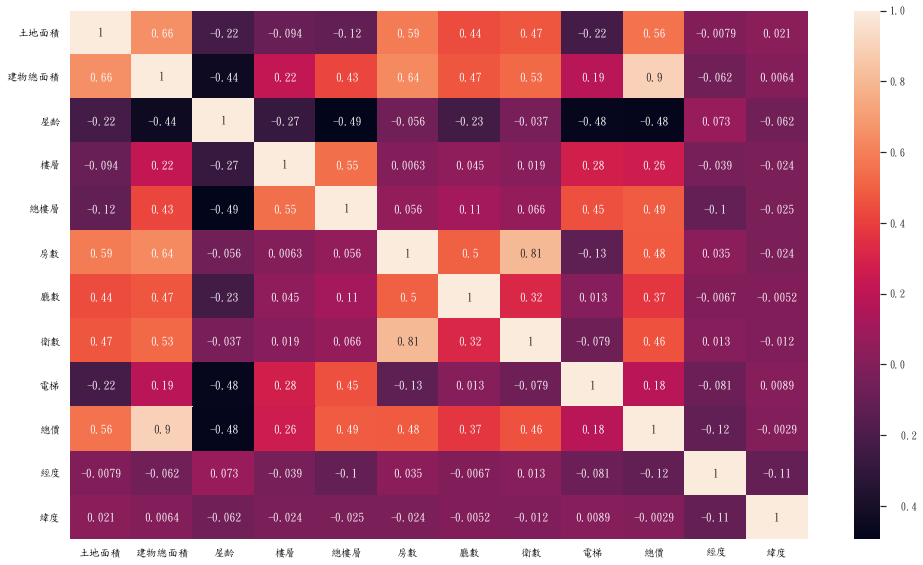

In [6]:
corr_mat = train.corr()
plt.figure(figsize=(17, 10), dpi=70)
sns.heatmap(corr_mat, annot=True)
plt.show()

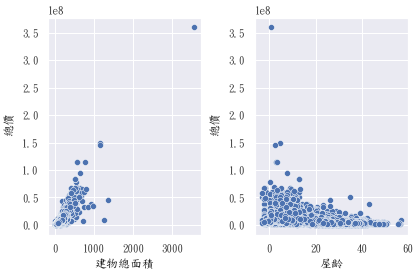

In [7]:
plt.subplot(1, 2, 1)
sns.scatterplot(data=train, x="建物總面積", y="總價")

plt.subplot(1, 2, 2)
sns.scatterplot(data=train, x="屋齡", y="總價")

plt.tight_layout()
plt.show()

* 處理異常值

(29999, 16)


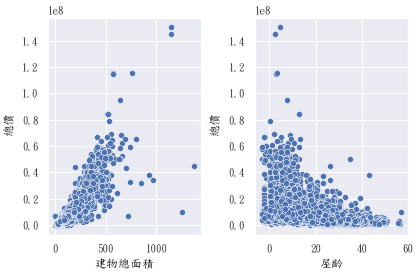

In [8]:
# Deleting the outlier of 總價.(1)
train = train.drop(train[train["總價"] == pd.DataFrame.max(train["總價"])].index)
print(train.shape)

plt.subplot(1, 2, 1)
sns.scatterplot(data=train, x="建物總面積", y="總價")

plt.subplot(1, 2, 2)
sns.scatterplot(data=train, x="屋齡", y="總價")

plt.tight_layout()
plt.show()

In [9]:
train.describe()

,土地面積,建物總面積,屋齡,樓層,總樓層,房數,廳數,衛數,電梯,總價,經度,緯度
count,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,29999.000000,2.999900e+04,29953.000000,29953.000000
mean,19.123365,136.298076,15.548241,7.431148,13.158272,2.706457,1.695823,1.773892,0.913197,8.410590e+06,120.664706,24.158740
std,11.157137,74.653496,12.406256,4.285963,5.647998,1.106850,0.688582,0.866811,0.281551,6.977497e+06,0.035159,0.033650
min,0.100000,0.020000,-3.408694,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,120.519425,23.975744
25%,11.300000,89.760000,2.622915,4.000000,9.000000,2.000000,1.000000,1.000000,1.000000,4.340000e+06,120.644049,24.140208
50%,18.010000,128.040000,18.461707,7.000000,13.000000,3.000000,2.000000,2.000000,1.000000,6.800000e+06,120.667739,24.160029
75%,25.210000,165.990000,25.054587,10.000000,15.000000,3.000000,2.000000,2.000000,1.000000,1.024250e+07,120.688996,24.175839
max,259.850000,1370.130000,56.989534,30.000000,41.000000,33.000000,33.000000,33.000000,1.000000,1.500000e+08,121.332710,24.999759


In [10]:
# Transfer those 總價 is 0 to NaN.(4)
train.loc[train[train["總價"] == 0].index, "總價"] = np.nan

# Fill the mean through the column of 行政區, where 總價 is 0.
train_mean = train.groupby(by="行政區").mean()
西屯區 = train_mean["總價"]["西屯區"]
大里區 = train_mean["總價"]["大里區"]

idx_大里區 = train[(train["總價"].isnull())&(train["行政區"] == "大里區")].index
train.loc[idx_大里區, "總價"] = 大里區

idx_西屯區 = train[(train["總價"].isnull())&(train["行政區"] == "西屯區")].index
train.loc[idx_西屯區, "總價"] = 西屯區

In [11]:
# Deleting the outliers where 樓層 > 總樓層.(2)
idx_floor = train[train["樓層"] > train["總樓層"]].index
train = train.drop(idx_floor)

In [12]:
# Deleting the outliers of 房數.(2)
idx_room = train[train["房數"] == 33].index
train = train.drop(idx_room)

* 缺失值處理

In [13]:
train.isnull().sum()

行政區       0
土地面積      0
建物總面積     0
屋齡        0
樓層        0
總樓層       0
用途        0
房數        0
廳數        0
衛數        0
電梯        0
車位類別      0
交易日期      0
總價        0
經度       46
緯度       46
dtype: int64

In [14]:
# Deleting the missing value where in longtitude and latitude.(46)
idx = train[train["經度"].isnull()].index
train = train.drop(idx)

* 分析預測項 (總價）
* 參考資料：[scipy.stats.probplot](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html)

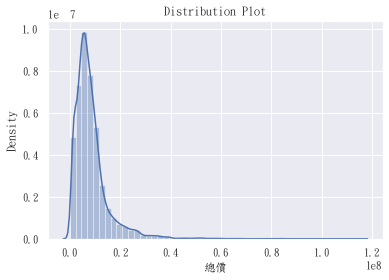

In [15]:
# Plot the distribution of 總價.
plt.figure()
sns.distplot(train["總價"])
plt.title("Distribution Plot")
plt.ylabel("Density")
plt.show()

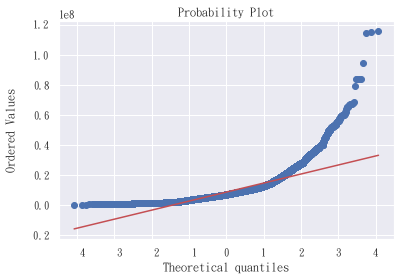

In [16]:
# Plot the QQ-plot of 總價.
plt.figure()
qq_plot = stats.probplot(train["總價"], plot=plt)
plt.show()

* 對總價做對數轉換
* $y=ln(10x)+1$

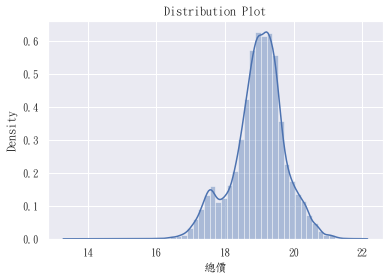

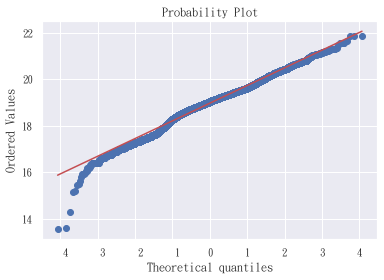

In [17]:
train["總價"] = np.log(10*train["總價"]) + 1  # Remember to switch back.

# Plot the distribution and qq-plot after transform.
plt.figure(0)
sns.distplot(train["總價"], kde=True)
plt.ylabel("Density")
plt.title("Distribution Plot")
plt.show()

plt.figure(1)
qq_plot = stats.probplot(train["總價"], plot=plt)
plt.show()

In [18]:
print("train data size :", train.shape)
train.head()

train data size : (29949, 16)


,行政區,土地面積,建物總面積,屋齡,樓層,總樓層,用途,房數,廳數,衛數,電梯,車位類別,交易日期,總價,經度,緯度
0,北區,33.82,98.05,39.373841,4,5,住,5,0,5,0,無,2020/5/21,19.035018,120.688340,24.158833
1,南區,26.49,174.63,16.638261,4,9,住,4,2,2,1,坡道平面,2018/8/15,19.304147,120.652024,24.119312
2,東區,30.64,182.10,3.370364,2,13,住,3,2,2,1,坡道平面,2019/8/1,19.515991,120.698961,24.127846
3,中區,1.65,33.76,22.793076,12,19,商,1,1,1,1,無,2019/3/6,17.300417,120.677840,24.146457
4,北區,22.00,90.64,24.819127,5,5,住,3,2,2,0,無,2019/5/17,18.686712,120.663874,24.160882


## 特徵處理
***
* 切割數據集
    * 如果輸入Y，則為進行預測動作

In [19]:
Do = "N"

In [20]:
if Do == "Y":
    X_train = train.drop(["總價"], axis = 1)
    y_train = train["總價"]
    X_test = test
    X_test, y_pred = X_test.drop(["id"], axis = 1), X_test.loc[:, ["id"]]
    
else:
    X = train.drop(["總價"], axis = 1)
    y = train["總價"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/29, shuffle = True, random_state = 47)
    print("X_train data size :", X_train.shape)
    print("X_test data size :", X_test.shape)

X_train data size : (28916, 15)
X_test data size : (1033, 15)


* 標準化（Standardization）

In [21]:
scaler = StandardScaler()
scaler.fit_transform(X_train.loc[:, "土地面積":"屋齡"]);
scaler.fit_transform(X_test.loc[:, "土地面積":"屋齡"]);

In [22]:
train.head()

,行政區,土地面積,建物總面積,屋齡,樓層,總樓層,用途,房數,廳數,衛數,電梯,車位類別,交易日期,總價,經度,緯度
0,北區,33.82,98.05,39.373841,4,5,住,5,0,5,0,無,2020/5/21,19.035018,120.688340,24.158833
1,南區,26.49,174.63,16.638261,4,9,住,4,2,2,1,坡道平面,2018/8/15,19.304147,120.652024,24.119312
2,東區,30.64,182.10,3.370364,2,13,住,3,2,2,1,坡道平面,2019/8/1,19.515991,120.698961,24.127846
3,中區,1.65,33.76,22.793076,12,19,商,1,1,1,1,無,2019/3/6,17.300417,120.677840,24.146457
4,北區,22.00,90.64,24.819127,5,5,住,3,2,2,0,無,2019/5/17,18.686712,120.663874,24.160882


* 用途（Label Encoding）

In [23]:
X_train["用途"] = [0 if x =='商' else 1 for x in X_train["用途"].values]
X_test["用途"] = [0 if x =='商' else 1 for x in X_test["用途"].values]
X_train.head()

,行政區,土地面積,建物總面積,屋齡,樓層,總樓層,用途,房數,廳數,衛數,電梯,車位類別,交易日期,經度,緯度
13706,清水區,14.61,160.08,-0.427113,5,15,0,3,2,2,1,坡道平面,2019/8/7,120.542016,24.268656
11771,中區,9.71,35.28,40.367701,5,6,1,1,0,1,1,無,2017/11/6,120.684957,24.141939
22251,南屯區,17.73,182.20,6.622997,12,14,1,4,2,2,1,坡道平面,2019/5/12,120.618162,24.158269
12997,梧棲區,16.83,69.50,40.162358,5,5,1,3,1,1,0,無,2020/2/25,120.556106,24.240226
10556,西區,22.32,235.77,24.879361,3,13,1,4,2,2,1,坡道平面,2019/8/13,120.655258,24.141161


* 車位類別：先判斷有無車位，再進行Label Encoding

In [24]:
X_train['車位類別'] = [0 if use =='無' else 1 for use in X_train['車位類別'].values]
X_test['車位類別'] = [0 if use =='無' else 1 for use in X_test['車位類別'].values]
X_train.head()

,行政區,土地面積,建物總面積,屋齡,樓層,總樓層,用途,房數,廳數,衛數,電梯,車位類別,交易日期,經度,緯度
13706,清水區,14.61,160.08,-0.427113,5,15,0,3,2,2,1,1,2019/8/7,120.542016,24.268656
11771,中區,9.71,35.28,40.367701,5,6,1,1,0,1,1,0,2017/11/6,120.684957,24.141939
22251,南屯區,17.73,182.20,6.622997,12,14,1,4,2,2,1,1,2019/5/12,120.618162,24.158269
12997,梧棲區,16.83,69.50,40.162358,5,5,1,3,1,1,0,0,2020/2/25,120.556106,24.240226
10556,西區,22.32,235.77,24.879361,3,13,1,4,2,2,1,1,2019/8/13,120.655258,24.141161


* 把交易日期更換為該年月消費者物價指數
* 資料來源：[中華民國統計資訊網](https://www.stat.gov.tw/ct.asp?xItem=47731&ctNode=489&mp=4)

In [25]:
cpi = pd.read_csv("CPI_.csv", encoding="UTF-8")
dict_cpi = cpi.set_index('year_')["cpi_"].to_dict()

In [26]:
X_train_date, X_test_date = [], []
for year in list(X_train["交易日期"]):
    X_train_date.append(year[:6])
for year in list(X_test["交易日期"]):
    X_test_date.append(year[:6])
X_train["交易日期"] = X_train_date
X_test["交易日期"] = X_test_date
X_train["交易日期"] = X_train["交易日期"].map(dict_cpi)
X_test["交易日期"] = X_test["交易日期"].map(dict_cpi)
X_train.head()

,行政區,土地面積,建物總面積,屋齡,樓層,總樓層,用途,房數,廳數,衛數,電梯,車位類別,交易日期,經度,緯度
13706,清水區,14.61,160.08,-0.427113,5,15,0,3,2,2,1,1,102.84,120.542016,24.268656
11771,中區,9.71,35.28,40.367701,5,6,1,1,0,1,1,0,100.32,120.684957,24.141939
22251,南屯區,17.73,182.20,6.622997,12,14,1,4,2,2,1,1,102.64,120.618162,24.158269
12997,梧棲區,16.83,69.50,40.162358,5,5,1,3,1,1,0,0,102.17,120.556106,24.240226
10556,西區,22.32,235.77,24.879361,3,13,1,4,2,2,1,1,102.84,120.655258,24.141161


* 行政區（Target Encoding）

In [27]:
tarcoder = TargetEncoder(cols=["行政區"])
X_train = tarcoder.fit_transform(X_train, y_train)
X_test = tarcoder.transform(X_test)
X_train.head()

,行政區,土地面積,建物總面積,屋齡,樓層,總樓層,用途,房數,廳數,衛數,電梯,車位類別,交易日期,經度,緯度
13706,18.748834,14.61,160.08,-0.427113,5,15,0,3,2,2,1,1,102.84,120.542016,24.268656
11771,17.616673,9.71,35.28,40.367701,5,6,1,1,0,1,1,0,100.32,120.684957,24.141939
22251,19.385902,17.73,182.20,6.622997,12,14,1,4,2,2,1,1,102.64,120.618162,24.158269
12997,18.309698,16.83,69.50,40.162358,5,5,1,3,1,1,0,0,102.17,120.556106,24.240226
10556,18.774790,22.32,235.77,24.879361,3,13,1,4,2,2,1,1,102.84,120.655258,24.141161


In [28]:
X_train.isnull().sum()

行政區      0
土地面積     0
建物總面積    0
屋齡       0
樓層       0
總樓層      0
用途       0
房數       0
廳數       0
衛數       0
電梯       0
車位類別     0
交易日期     0
經度       0
緯度       0
dtype: int64

## 建置模型
***
* 模型選擇
    * LinearRegression
    * RandomForestRegressor

* 利用網格搜索找尋最佳參數

In [29]:
Models = {"LR":LinearRegression(),
          "RF":RandomForestRegressor()}

Parameters_Grids = {"LR":{"n_jobs":[-1]},
                    "RF":{"n_estimators":[100, 150, 200],
                          "max_depth":[6, 8, 12, 16],
                          "n_jobs":[-1]}}

* 測試模型表現

In [30]:
if Do == "Y":
    Model = RandomForestRegressor(max_depth=16, n_estimators=200, n_jobs=-1)
    Model.fit(X_train, y_train)
    Pred = Model.predict(X_test)
    Pred = 1/10 * np.exp(Pred-1)
    y_pred["總價"] = Pred
    y_pred["總價"] = y_pred["總價"].astype(int)
    print(y_pred.head())
    y_pred.to_csv("Submission.csv", index=False)

else:
    Test_Results = {}
    y_test = 1/10 * np.exp(y_test-1)
    for Model in Models.keys():
        GS = GridSearchCV(Models[Model], Parameters_Grids[Model], n_jobs = -1)
        GS.fit(X_train, y_train)
        print(GS.cv_results_["mean_test_score"], GS.cv_results_["std_test_score"])
        print(GS.best_params_)
        Pred = GS.predict(X_test)
        Pred = 1/10 * np.exp(Pred-1)
        Test_Results[Model] = mean_squared_error(y_test, Pred, squared = False)
        print("Testing_RMSE:", Test_Results[Model])
        print("Testing_R-Square:", r2_score(y_test, Pred))

[0.85208793] [0.01461321]
{'n_jobs': -1}
Testing_RMSE: 2504662.4547967585
Testing_R-Square: 0.8708115735749771
[0.91398979 0.91416201 0.914224   0.92895266 0.92892689 0.92879798
 0.94309529 0.94295007 0.94287411 0.94707966 0.94759544 0.94742991] [0.00268288 0.00257669 0.00255846 0.00240325 0.00246357 0.00253695
 0.00316104 0.00309416 0.00320044 0.00332763 0.00317453 0.00314966]
{'max_depth': 16, 'n_estimators': 150, 'n_jobs': -1}
Testing_RMSE: 1535057.1819944468
Testing_R-Square: 0.9514740202364566


## 模型表現
***
* Train Data Score
* Test Data Score
* 殘差分析

In [31]:
def plot_resid(y_train, y_test, y_train_pred, y_test_pred):
    y_train_resid = np.array(y_train_pred - y_train).reshape(-1, 1)
    y_test_resid = np.array(y_test_pred - y_test).reshape(-1, 1)
    scaler = StandardScaler()
    y_train_resid = scaler.fit_transform(y_train_resid)
    scaler = StandardScaler()
    y_test_resid = scaler.fit_transform(y_test_resid)
    fig, ax = plt.subplots()
    sns.residplot(y_train_pred, y_train_resid, lowess=True,
                  label='Train data', scatter_kws={'s': 25}, 
                  line_kws={'color': 'b', 'lw':2}, ax=ax)
    sns.residplot(y_test_pred, y_test_resid, lowess=True,
                  label='Test data', scatter_kws={'s': 25}, 
                  line_kws={'color': 'orange', 'lw':2}, ax=ax)

    plt.legend()
    plt.xlabel('Predicted Price')
    plt.ylabel('Residual')
    plt.grid()

RMSE(train) : [733289.7020208447, 731304.9165706928, 721066.812469864, 738758.5288705995, 734124.378382395, 730203.2679558963, 734228.7951763767, 744192.4075632513, 739805.3419634353, 728105.6989179929]
RMSE(mean) : 733507.9849891348


RMSE(test) : [1458994.194494671, 1479185.7659172958, 1352352.1259252583, 1482029.2087893907, 1542393.5368657727, 1563673.9153028314, 1630564.5148530197, 1517441.2038966801, 1500179.2286034971, 1447125.555915802]
RMSE(mean) : 1497393.925056422


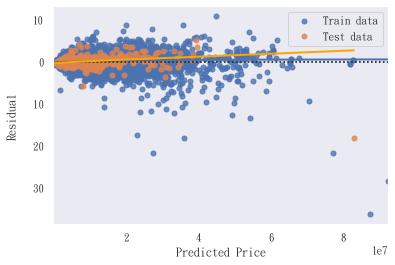

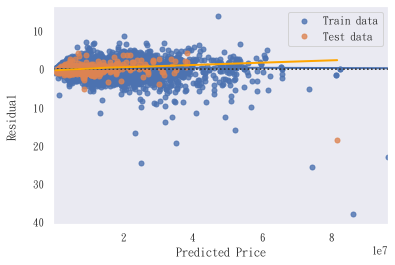

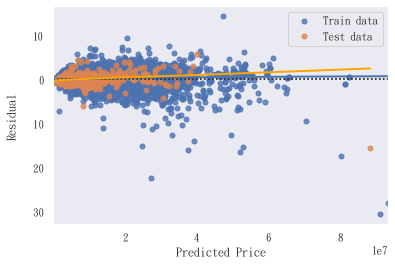

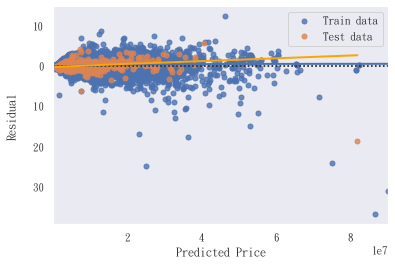

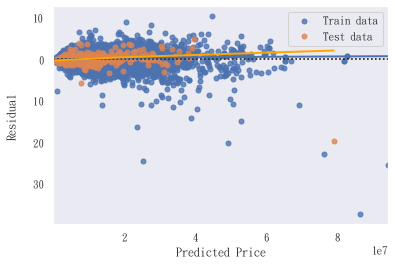

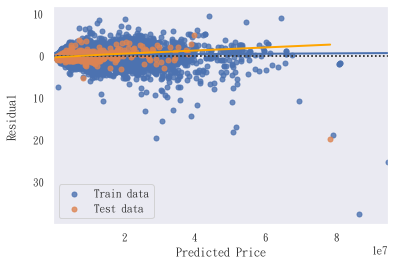

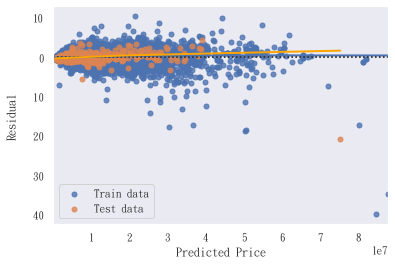

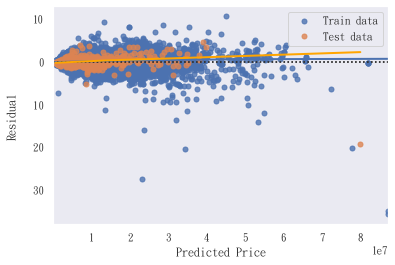

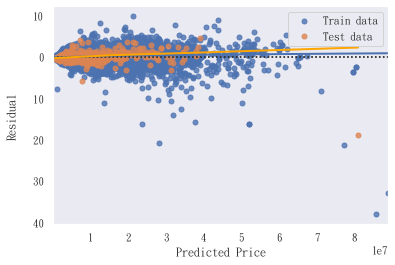

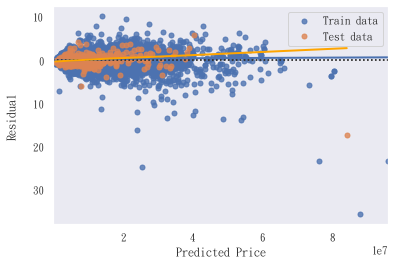

In [32]:
kf = KFold(n_splits=10)
train_rmse, test_rmse=[], []
# y_train = 1/10 * np.exp(y_train-1)
# y_test = 1/10 * np.exp(y_test-1)
for loop_number, (train, test) in enumerate(kf.split(X_train)):

    RF = RandomForestRegressor(n_estimators=150, max_depth=16, n_jobs=-1)
    RF.fit(X_train, y_train)
    y_train_pred = 1/10 * np.exp(RF.predict(X_train)-1)
    y_test_pred = 1/10 * np.exp(RF.predict(X_test)-1)
    train_score = mean_squared_error(1/10 * np.exp(y_train-1), y_train_pred, squared=False)
    test_score = mean_squared_error(y_test, y_test_pred, squared=False)
    plot_resid(1/10 * np.exp(y_train-1), y_test, y_train_pred, y_test_pred)
    train_rmse.append(train_score)
    test_rmse.append(test_score)
print("RMSE(train) :", train_rmse)
print("RMSE(mean) :", sum(train_rmse)/len(train_rmse))
print("\n")
print("RMSE(test) :", test_rmse)
print("RMSE(mean) :", sum(test_rmse)/len(test_rmse))